In [3]:
!pip install -U rioxarray

  Using cached rioxarray-0.9.1-py3-none-any.whl
  Using cached xarray-0.20.2-py3-none-any.whl (845 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
import os
import rasterio
from rasterio.plot import show
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import pandas as pd
import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

#### Read in vector file of polygon zones

     HYBAS_ID  NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0  3060000010          0  3060000010  3060000010        0.0        0.0   
1  3060000150          0  3060000150  3060000150        0.0        0.0   
2  3060000160          0  3060000160  3060000160        0.0        0.0   
3  3060000230          0  3060000230  3060000230        0.0        0.0   
4  3060000240          0  3060000240  3060000240        0.0        0.0   

   SUB_AREA                                           geometry  
0    7144.1  MULTIPOLYGON (((67.39861 68.75000, 67.39258 68...  
1    5062.5  POLYGON ((70.37083 68.05417, 70.38159 68.05452...  
2    2164.9  MULTIPOLYGON (((69.05811 68.91980, 69.05653 68...  
3    9951.2  POLYGON ((70.00417 69.19167, 70.00507 69.19517...  
4   11581.4  MULTIPOLYGON (((66.99028 69.48333, 66.95918 69...  
CPU times: user 13.2 s, sys: 465 ms, total: 13.6 s
Wall time: 13.6 s


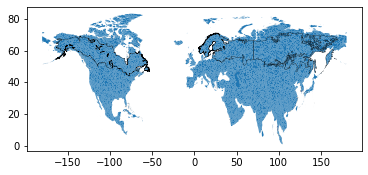

In [12]:
%%time
# Boreal
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')

# Get the shp filename
shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/arc/bioclimate_dd.shp'
HYBAS_LEV = 'lev06'
shp_fn = f'/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_{HYBAS_LEV}_v1c.shp'
vector_gdf = gpd.read_file(shp_fn) 
print(vector_gdf.head())

vector_file_name = 'bioclimate_dd'
vector_file_name = f'hybas_{HYBAS_LEV}'

zone_field_name = 'zone_'
zone_field_name = 'HYBAS_ID'

ax=vector_gdf.plot()
boreal_gdf.boundary.plot(linewidth=0.25, color='black', ax=ax)

### Select watersheds that intersect boreal domain

In [11]:
boreal_gdf

,OBJECTID,REALM,Shape_Leng,Shape_Area,geometry
0,1.0,NA,8.945199e+07,6.536703e+12,"MULTIPOLYGON (((-80.07693 45.33184, -80.07336 ..."
1,2.0,PA,1.386740e+08,1.254836e+13,"MULTIPOLYGON (((168.02261 54.60243, 168.03862 ..."


## New approach from Analyze AGB
* /projects/Developer/icesat2_boreal/notebooks/5.Publish_Data/Analyze_AGB.ipynb

#### get raster crs

In [59]:
vrt_fn = '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'

import rasterio.crs

with rasterio.open(vrt_fn, mode='r') as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.indexes)
    raster_crs = src.crs

165000 204000
PROJCS["unknown",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
(1,)


#### Clip vector and reproject to raster crs

CPU times: user 5min 13s, sys: 404 ms, total: 5min 14s
Wall time: 5min 13s


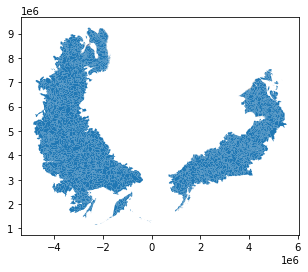

In [22]:
%%time
in_gdf = vector_gdf[ (vector_gdf.intersects(boreal_gdf.iloc[0].geometry)) | (vector_gdf.intersects(boreal_gdf.iloc[1].geometry)) ].to_crs(raster_crs)
in_gdf.plot()

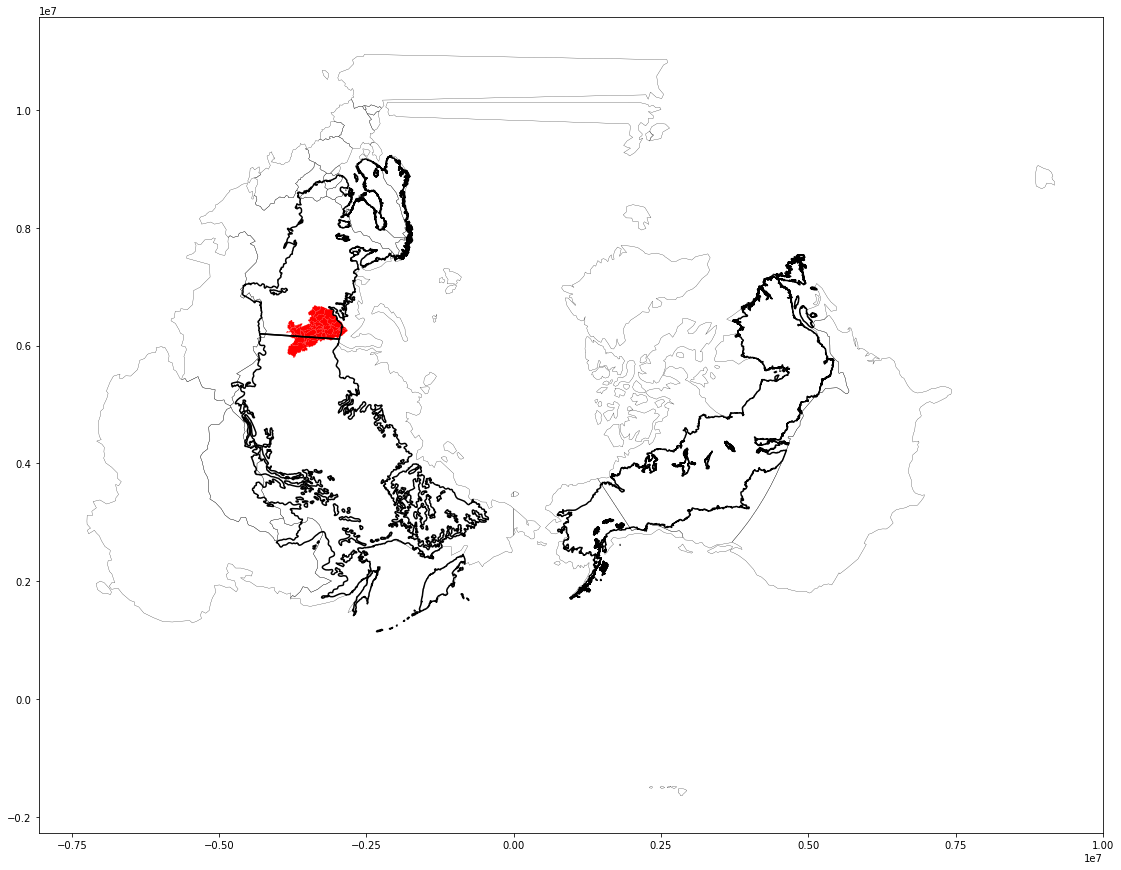

In [87]:
ax = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") ).cx[-180:180,50:90].to_crs(raster_crs).boundary.plot(color='black', linewidth=0.25)
ax = boreal_gdf.to_crs(raster_crs).boundary.plot(color='black', ax=ax)
in_gdf.head(50).plot(ax=ax, color='red')

### Problem matching CRS of raster with vector?
* we see they match, but the zonal_stats returns 'None' values

In [63]:
test_gdf = in_gdf.reset_index(drop=True).to_crs(raster_crs).sample(n=50)
print(raster_crs)
print(test_gdf.crs)

PROJCS["unknown",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["unknown",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_par

In [64]:
%%time
import rasterstats
out_gdf = test_gdf.reset_index(drop=True).join(
        pd.DataFrame(
            rasterstats.zonal_stats(
                vectors=test_gdf['geometry'], 
                raster=vrt_fn, 
                stats=['max','mean', 'median','std','min','sum','count']
            )
        )
    )

CPU times: user 51.5 s, sys: 24.9 s, total: 1min 16s
Wall time: 6min


In [67]:
out_gdf.head()

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,geometry,max,mean,median,std,min,sum,count
0,4060154710,4060175960,4060000880,4060000880,2807.3,2807.3,41359.2,"POLYGON ((-3466470.922 2523312.943, -3467668.7...",NaN,NaN,NaN,NaN,NaN,NaN,0
1,7060214090,7069000120,7060022240,7060022240,875.8,875.8,3860.0,"POLYGON ((4296694.145 4411336.118, 4296748.133...",606.662903,36.502265,32.197601,22.817998,4.272060,155226320.0,4252512
2,8060152640,8069000080,8060009560,8060009560,1472.5,1472.5,567.0,"POLYGON ((2212579.151 3831813.318, 2211818.773...",603.324524,24.836809,21.449715,12.689509,4.394182,15546402.0,625942
3,7060262320,7060252580,7060024580,7060024580,108.4,108.4,2646.1,"POLYGON ((4739149.073 5401418.551, 4739117.388...",600.122864,35.378421,26.270939,29.291192,3.820121,102228496.0,2889572
4,8060003220,0,8060003220,8060003220,0.0,0.0,1493.4,"POLYGON ((1249345.779 2005322.237, 1249016.927...",652.464844,42.415897,35.923141,31.123961,4.294769,64609336.0,1523234


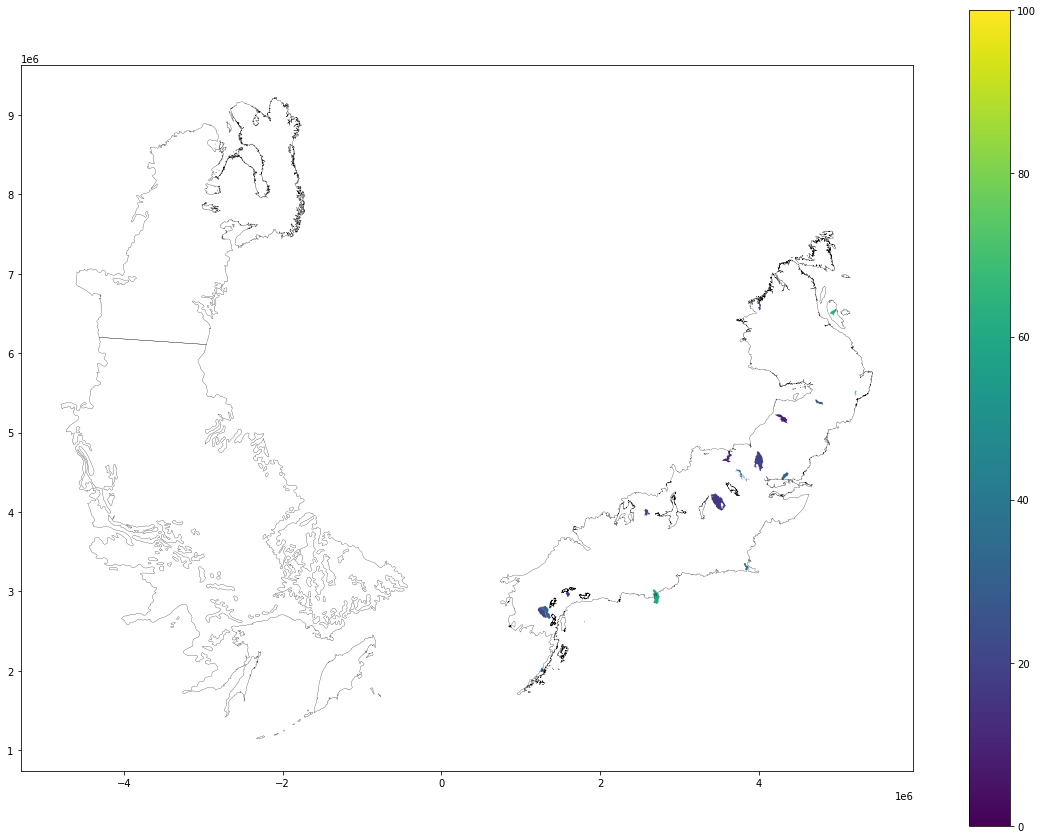

In [80]:
plt.rcParams['figure.figsize'] = [20, 15]
ax = boreal_gdf.to_crs(raster_crs).boundary.plot(color='black', linewidth=0.25)
out_gdf.plot('median', cmap='viridis', legend=True, vmin=0, vmax=100, ax=ax)

#### Specify raster file

In [38]:
indir = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/worldclim/1km/bioclim/wc2.0_30s_bio'
outdir = '/att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip'
r_fn = os.path.join(indir, 'wc2.0_bio_30s_05.tif')


### Approach 1 (complicated?, but handles clipping and saving)
#### Iterate over polygon features of a vector file, clip raster by each feature, summarize raster values and save as CSV
##### This lets you clip by a bunch of features in a polygon vector - not by each indiv feature
https://kodu.ut.ee/~kmoch/geopython2019/L4/raster.html#clipping-a-raster
##### Below adapts this, looping over each feature in 'shapes'

##### First, get a geoms list of the features

/att/gpfsfs/home/appmgr/app/jupyterhub/ilab/ilab-kernel/lib/python3.7/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


# of indiv features: 29


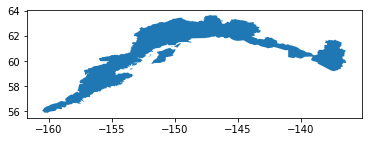

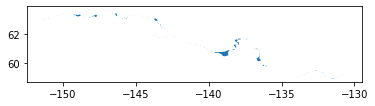

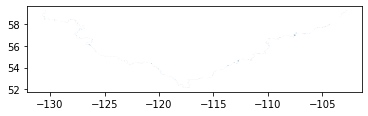

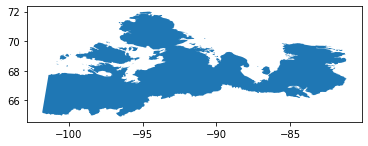

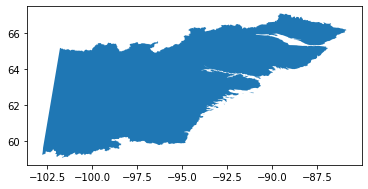

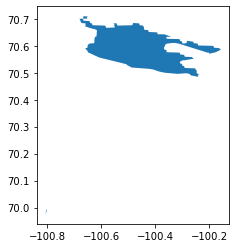

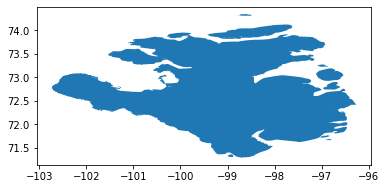

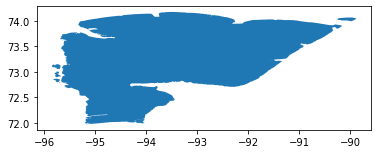

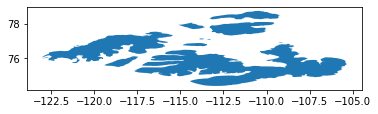

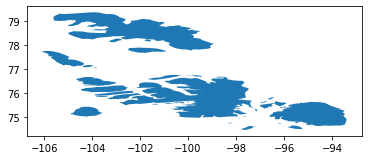

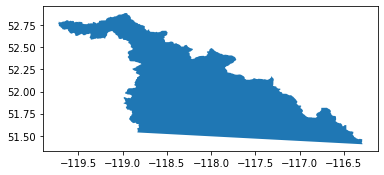

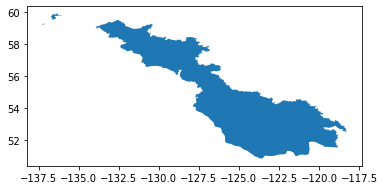

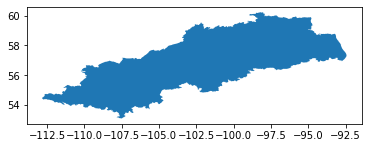

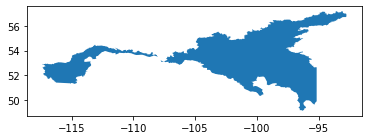

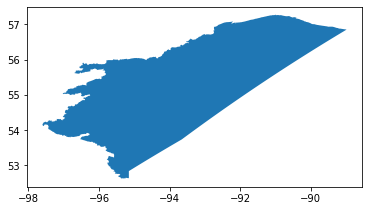

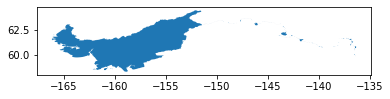

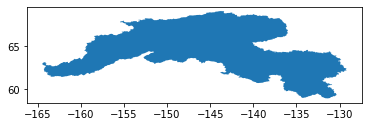

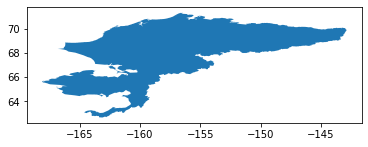

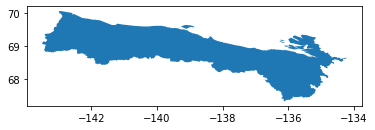

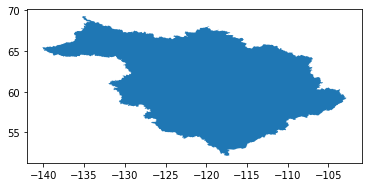

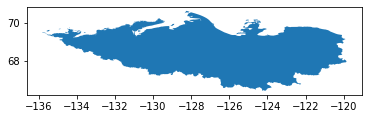

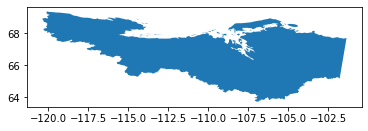

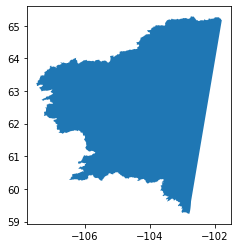

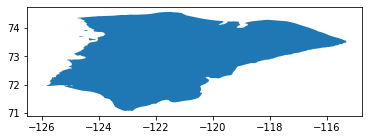

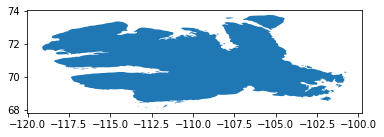

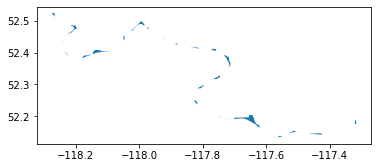

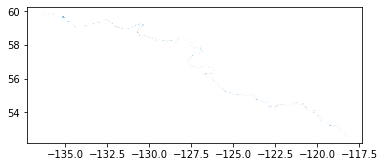

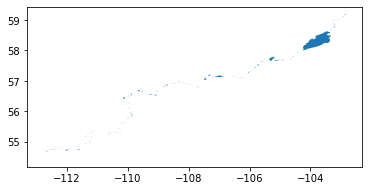

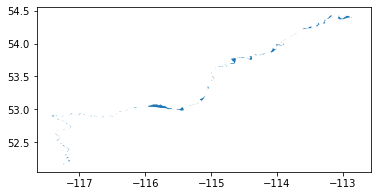

In [68]:

geoms_list = []
zone_name_list = []

for idx in vector_gdf.index:
    #print(idx)
    geom =  vector_gdf.loc[idx].geometry
    zonename =  vector_gdf.loc[idx][zone_field_name]
    
    if geom not in geoms_list:
        gpd.GeoSeries(geom).plot()
        geoms_list.append(geom)
        zone_name_list.append(zonename)

print(f'# of indiv features: {len(geoms_list)}')

In [75]:
SHOW_CLIP = False

feature_fail_list = []
no_raster_intersection_list = []

with rasterio.open(r_fn, "r") as r:
    
    ##with fiona.open(shp_fn, "r") as vectorfile:

        ##shapes = [feature["geometry"] for feature in vectorfile]
        #print(shapes[0])
        
        ##for i, shp in enumerate(shapes):
        
    for idx, zone_name in enumerate(zone_name_list):
        print(zone_name)
        geom = geoms_list[idx]
        
        try:
            feature_gdf = gpd.GeoDataFrame({'name':zone_name, 'geometry':geom}, crs=from_epsg(4326)) #index=[0], 
            #feature_gdf.plot(zone_name)
        except ValueError:
            print(f"Cant get geodataframe for feature {zone_name}")
            feature_fail_list.append(zone_name)

        # Reproject feature_gdf to raster crs
        feature_gdf = feature_gdf.to_crs(r.crs)

        zone_name = f'{zone_name:03}'
        out_r_fn = os.path.join(os.path.split(r_fn.replace(indir, outdir))[0] , os.path.split(r_fn)[1].replace('.tif', '_'+vector_file_name+'_'+zone_name+'.tif'))

        try:

            out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=feature_gdf.geometry, crop=True)

            # Copy the metadata
            out_meta = r.meta.copy()
            out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "crs":r.crs.to_proj4()}
                             )
            with rasterio.open(out_r_fn, "w", **out_meta) as out_r:
                out_r.write(out_image)

                print("Zone", zonenum, "clip of",  os.path.split(r_fn)[1])
                print("Writing clipped subset to", out_r_fn)
                
                #show(out_r, cmap='viridis') # <-- this show() is not working here..need to read the raster in again?
             
            # HERE IS WHERE WE CAN DO rasterstat's zonal_stats.
            if SHOW_CLIP:
                show((rasterio.open(out_r_fn)), cmap='viridis')# <-- this show() works

        except ValueError:
            print(zone_name, " has no intersection with", os.path.split(r_fn)[1])
            no_raster_intersection_list.append(zone_name)

print(f'# features that failed to produce geodataframes: {len(feature_fail_list)}')
print(f'# features that didnt have intersection with raster: {len(no_raster_intersection_list)}')

8030000010
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030000010.tif
8030005510
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030005510.tif
8030009560
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030009560.tif
8030010700
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030010700.tif
8030016860
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030016860.tif
8030024130
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writ

### Approach 2 (simpler?, but doesnt handle clipping)
##### This zonalstats approach should return a table of counts for each categorical raster value for each vector polygon 'zone'

In [1]:
import rasterstats
from rasterstats import zonal_stats

zs = zonal_stats(shp_fn, r_fn, categorical=True)

ModuleNotFoundError: No module named 'rasterstats'